## initial setups

In [23]:
import pyomo.environ as pyo
solver = pyo.SolverFactory('gurobi')

import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']

plt.rcParams['svg.fonttype'] = 'none'
import matplotlib as mpl
mpl.rcParams["axes.unicode_minus"] = False

import pypowsybl as pp

from collections import namedtuple

import pprint
prettyp = pprint.PrettyPrinter(indent = 4)
prettyfy = prettyp.pprint

import math

import time

from dataclasses import dataclass
from collections.abc import Callable


# Simple 3-bus case

## case
In that case, Bus 1 and bus 2 are in the same substation. Line 1-2 is the internal connection: if it (its switch) is open, there are 2 nodes else only 1.

![myimage.png](./simple%203%20bus%20case.svg)

## results

### ploting functions

#### boundary lines
if $sw=0$, the boundary line is  $P_{0i} = \overline{P_{0i}}$

if $sw=1$, then 

$$
\begin{pmatrix} P_{01} \\ P_{02} \\ P_{12} \end{pmatrix}
= \frac{1}{b_{01} + b_{02}}
	\begin{pmatrix}
		b_{01} & b_{01} \\ b_{02} & b_{02} \\ -b_{02} & b_{01}
	\end{pmatrix}
	\begin{pmatrix}P_1 \\ P_2\end{pmatrix}
$$

Therefore $P_{0i} = \frac{b_{0i}}{b_{01} + b_{02}} * P_i$ and the boundary line for connected operation is:
$ P_1 + P_2 = \min({\frac{b_{01} + b_{02}}{b_{0i}}\overline{P_{0i}}})  $

In [24]:
def plot_results_frame(P01M, P02M, b01, b02):
    coef = 2
    nb = 20
    vec_range = [coef * i / nb for i in range(nb+1)]

    plt.plot([p1*P01M for p1 in vec_range], [P02M for i in range(nb+1)], color = 'red')
    plt.plot([P01M for i in range(nb+1)], [p2*P02M for p2 in vec_range], color = 'red')
    plt.plot([p1 * P01M for p1 in vec_range], [min((1+b02/b01) * P01M, (1+b01/b02) * P02M)- p1 * P01M for p1 in vec_range], color = 'blue')
    plt.xlabel('P1')
    plt.ylabel('P2')
    plt.xlim(0, P01M * coef)
    plt.ylim(0, P02M * coef)

def plot_results(P1, P2, ls1, ls2, sw, show_orig = False, show_target = False):
    if show_orig:
        ls = ls1 + ls2
        plt.scatter(P1, P2, s = 10 if ls == 0 else (10 * ls) ** 2, marker = 'x' if ls == 0 else 'o', color = 'red' if sw == 0 else 'blue')
    if show_target:
        plt.plot(P1 - ls1, P2 - ls2, 'x', color = 'red' if sw == 0 else 'green')


In [25]:
def single_result(model_builder, P01M, P02M, b01, b02, P1, P2):
    model = model_builder(P01M, P02M, b01, b02, P1, P2,)
    print(solver.solve(model))
    plot_results_frame(P01M, P02M,b01, b02)
    res = model.get_result()
    plot_results(P1, P2, *res, True, True)
    print(f"sw: {res[2]}, ls1: {res[0]}, ls2: {res[2]}, total ls = {res[0] + res[1]}")


In [26]:
def build_grid_results(model_builder, solver, P01M, P02M, b01, b02, nb, coef):
    result = [[(0, 0) for _ in range(nb + 1)] for _ in range(nb + 1)]
    for i in range(nb + 1):
        for j in range(nb + 1):
            P1 = coef * P01M * i / nb
            P2 = coef * P02M * j / nb
            model = model_builder(P01M, P02M, b01, b02, P1, P2)
            solver.solve(model)
            result[i][j] = (P1, P2, *model.get_result())
    return result

def plot_grid_results(P01M, P02M, b01, b02, result):
    plot_results_frame(P01M, P02M,b01, b02)
    for i, i_list in enumerate(result):
        for j, (P1, P2, ls1, ls2, sw) in enumerate(i_list):
            plot_results(P1, P2, ls1, ls2, sw, True, False)

def grid_results(model_builder, solver, P01M, P02M, b01, b02, nb, coef):
    plot_grid_results(P01M, P02M, b01, b02, build_grid_results(model_builder, solver, P01M, P02M, b01, b02, nb, coef))

## Model

cost to minimize = $\sum{ls_i} - \alpha * sw$ (load shedding bus $i$: $ls_i$. switch state : $sw=1$ if closed, $sw=0$ if open)

$|\theta_2 - \theta_1| \le (1-sw) \times M$

### case $sw = 0 \implies \theta_1 \neq \theta_2$

$ P_{0i} = b_{0i} \theta_i = P_i^* = P_i - ls_i \le \overline{P_{0i}} \implies P_i - ls_i - sw.M \le \overline{P_{0i}}$

$ 0 \le ls_i \le P_i $

### case $sw = 1 \implies \theta_1 = \theta_2 = \theta $

$ \theta = \frac{P_{01}^* + P_{02}^*}{b_{01} + b_{02}}$ 

$ b_{0i}\theta_i \leq \overline{P_{0i}} \implies b_{0i} . \frac{P_1 + P_2 - ls_1 - ls_2}{b_{01} + b_{02}} - (1-sw)M \leq \overline{P_{0i}} $



In [27]:
def build_model(P01M, P02M, b01, b02, P1, P2):
    bM = 1e3

    model = pyo.ConcreteModel()
    model.ls1 = pyo.Var(bounds = (0, P1), domain = pyo.NonNegativeReals)
    model.ls2 = pyo.Var(bounds = (0, P2), domain = pyo.NonNegativeReals)
    model.sw = pyo.Var(domain = pyo.Binary)

    def constr_sw_open(p, ls, sw, bM, p_max):
        return p - ls - sw * bM <= p_max

    def constr_sw_close(p1, p2, ls1, ls2, b01, b02, sw, bM, p_max):
        return b01 / (b01 + b02) * (p1 + p2 - ls1 - ls2) - (1 - sw) * bM <= p_max

    model.const_open1 = pyo.Constraint(rule = constr_sw_open(P1, model.ls1, model.sw, bM, P01M))
    model.const_open2 = pyo.Constraint(rule = constr_sw_open(P2, model.ls2, model.sw, bM, P02M))
    model.const_close1 = pyo.Constraint(rule = constr_sw_close(P1, P2, model.ls1, model.ls2, b01, b02, model.sw, bM, P01M))
    model.const_close2 = pyo.Constraint(rule = constr_sw_close(P1, P2, model.ls1, model.ls2, b02, b01, model.sw, bM, P02M))

    model.obj = pyo.Objective(rule = model.ls1 + model.ls2 - model.sw/1000, sense = pyo.minimize)
    
    def get_result():
        return model.ls1.value, model.ls2.value, model.sw.value
    
    model.get_result = get_result
    return model

## results

### single result


Problem: 
- Name: x1
  Lower bound: 0.3999999999999999
  Upper bound: 0.3999999999999999
  Number of objectives: 1
  Number of constraints: 4
  Number of variables: 3
  Number of binary variables: 1
  Number of integer variables: 1
  Number of continuous variables: 2
  Number of nonzeros: 10
  Sense: minimize
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Wall time: 0.011404991149902344
  Error rc: 0
  Time: 0.34713006019592285
Solution: 
- number of solutions: 0
  number of solutions displayed: 0

sw: 0.0, ls1: 0.0, ls2: 0.0, total ls = 0.3999999999999999


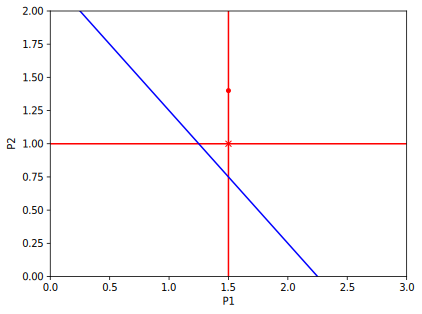

In [38]:
single_result(build_model, 1.5, 1, 1.25, 1, 1.5, 1.4)

### result grid

In [28]:
P01M, P02M = 1, .75
b01, b02 = 1, 2
nb, coef = 30, 2
grid_results(build_model, solver, P01M, P02M, b01, b02, nb, coef)

AttributeError: 'str' object has no attribute 'name'

<Figure size 640x480 with 1 Axes>

# Simple 3-bus case in Node-breaker modeling

## case
In that case, Bus 1 and bus 2 are in the same substation. Line 1-2 is the internal connection: if it (its switch) is open, there are 2 nodes else only 1.

![myimage.png](./simple%203%20bus%20case%20NB.svg)

## Model

### $sw = 1 \implies idem $ previous case

## $sw = 0$
### Constraints on flows

$P_{0i} \le \overline{P_{01}} \implies sw_i . P_1 + (1-sw_i)P_2 - sw . M \le \overline{P_{0i}}$

$sw_i = 0 \implies P_2 - sw.M \le \overline{P_{0i}} \implies P2 - sw.M - sw_i.M \le \overline{P_{0i}}$

$sw_i = 1 \implies P1 - sw.M \le \overline{P_{0i}} \implies P1 - sw.M - (1-sw_i).M \le \overline{P_{0i}}$

### constraint on connectivity

$sw_1 + sw_2 = 1 \implies sw_1 + sw_2 \le 1 + sw_0 \ and \ sw_1 + sw_2 \ge 1 - sw_0 $

Note: it also ensures that the lines are connected to 2 different buses even if $sw=1$ - which is good anyway. If we don't want that effect, then multiply $sw_0$ by $M$ in the connectivity constraint.

## ConcreteModel implementation

In [60]:
def build_model_nb(P01M, P02M, b01, b02, P1, P2):
    bM = 1e3

    model = pyo.ConcreteModel()
    model.ls1 = pyo.Var(bounds = (0, P1), domain = pyo.NonNegativeReals)
    model.ls2 = pyo.Var(bounds = (0, P2), domain = pyo.NonNegativeReals)
    model.sw = pyo.Var(domain = pyo.Binary)
    model.sw1 = pyo.Var(domain = pyo.Binary)
    model.sw2 = pyo.Var(domain = pyo.Binary)
    
    def constr_sw_open_on_line(p, ls, sw , sw_line, bM, p_max):
        return p - ls - (sw + sw_line) * bM <= p_max
    
    def constr_sw_close(p1, p2, ls1, ls2, b01, b02, sw, bM, p_max):
        return b01 / (b01 + b02) * (p1 + p2 - ls1 - ls2) - (1 - sw) * bM <= p_max

    model.const_close1 = pyo.Constraint(rule = constr_sw_close(P1, P2, model.ls1, model.ls2, b01, b02, model.sw, bM, P01M))
    model.const_close2 = pyo.Constraint(rule = constr_sw_close(P1, P2, model.ls1, model.ls2, b02, b01, model.sw, bM, P02M))
    model.const_open11 = pyo.Constraint(rule = constr_sw_open_on_line(P2, model.ls2, model.sw, model.sw1, bM, P01M))
    model.const_open12 = pyo.Constraint(rule = constr_sw_open_on_line(P2, model.ls2, model.sw, model.sw2, bM, P02M))
    model.const_open21 = pyo.Constraint(rule = constr_sw_open_on_line(P1, model.ls1, model.sw, 1- model.sw1, bM, P01M))
    model.const_open22 = pyo.Constraint(rule = constr_sw_open_on_line(P1, model.ls1, model.sw, 1 - model.sw2, bM, P02M))
# connectivity
    model.const_connect1 = pyo.Constraint(rule = model.sw1 + model.sw2 - model.sw <= 1)
    model.const_connect2 = pyo.Constraint(rule = model.sw1 + model.sw2 + model.sw >= 1)
    
    model.obj = pyo.Objective(rule = model.ls1 + model.ls2 - model.sw/1000, sense = pyo.minimize)
    
    def get_result():
        return model.ls1.value, model.ls2.value, model.sw.value
    
    model.get_result = get_result
    
    return model


Problem: 
- Name: x1
  Lower bound: 0.0
  Upper bound: 0.0
  Number of objectives: 1
  Number of constraints: 8
  Number of variables: 5
  Number of binary variables: 3
  Number of integer variables: 3
  Number of continuous variables: 2
  Number of nonzeros: 24
  Sense: minimize
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Wall time: 0.00027680397033691406
  Error rc: 0
  Time: 0.11162185668945312
Solution: 
- number of solutions: 0
  number of solutions displayed: 0

sw: 0.0, ls1: 0.0, ls2: 0.0, total ls = 0.0


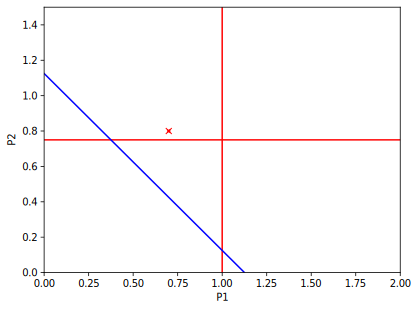

In [64]:
P01M, P02M = 1, .75
b01, b02 = 1, 2
P1, P2 = .7, .8
single_result(build_model_nb, P01M, P02M, b01, b02, P1, P2)

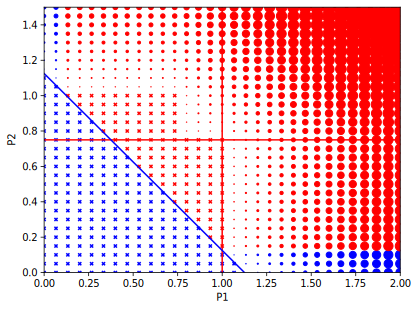

In [63]:
P01M, P02M = 1, .75
b01, b02 = 1, 2
nb, coef = 30, 2
grid_results(build_model_nb, solver, P01M, P02M, b01, b02, nb, coef)

## AbstractModel implementation

In [74]:
def build_model_nb_abstract(P01M, P02M, b01, b02, P1, P2):
    bM = 1e3
    
    p_list = {1: P1, 2: P2}

    model = pyo.AbstractModel()
    
    model.bus_set = pyo.Set(initialize = [1, 2])
    model.bus_set.construct()
    
    model.p = pyo.Param(model.bus_set, initialize = p_list)
    model.p_m = pyo.Param(model.bus_set, initialize = {1:P01M, 2:P02M})
    model.b = pyo.Param(model.bus_set, initialize = {1:b01, 2:b02})
    model.b_m = pyo.Param(initialize = bM)
    
    model.ls = pyo.Var(model.bus_set, bounds = {1: (0, P1), 2: (0, P2)}, domain = pyo.NonNegativeReals)
    model.sw = pyo.Var(domain = pyo.Binary)
    model.swi = pyo.Var(model.bus_set, domain = pyo.Binary)
    
    def constr_sw_open_on_line_a(m, i):
        return m.p[2] - m.ls[2] - (m.sw +  m.swi[i]) * m.b_m <= m.p_m[i]

    def constr_sw_open_on_line_b(m, i):
        return m.p[1] - m.ls[1] - (m.sw +  1 - m.swi[i]) * m.b_m <= m.p_m[i]
    
    def constr_sw_close(m, i):
        return m.b[i] / (m.b[1] + m.b[2]) * (m.p[1] + m.p[2] - m.ls[1] - m.ls[2]) - (1 - m.sw) * m.b_m <= m.p_m[i]

    model.constr_close = pyo.Constraint(model.bus_set, rule = constr_sw_close)

    model.const_open_a = pyo.Constraint(model.bus_set, rule = constr_sw_open_on_line_a)
    model.const_open_b = pyo.Constraint(model.bus_set, rule = constr_sw_open_on_line_b)

# connectivity
    model.const_connect1 = pyo.Constraint(rule = lambda m,i : pyo.summation(m.swi) - m.sw <= 1)
    model.const_connect2 = pyo.Constraint(rule = lambda m,i : pyo.summation(m.swi) + m.sw >= 1)
    
    model.obj = pyo.Objective(rule = lambda m,i : pyo.summation(m.ls) - m.sw/1000, sense = pyo.minimize)
    model.construct()
    
    def get_result():
        return model.ls[1].value, model.ls[2].value, model.sw.value

    model.get_result = get_result
    return model

### Single result


Problem: 
- Name: x1
  Lower bound: 0.0
  Upper bound: 0.0
  Number of objectives: 1
  Number of constraints: 8
  Number of variables: 5
  Number of binary variables: 3
  Number of integer variables: 3
  Number of continuous variables: 2
  Number of nonzeros: 24
  Sense: minimize
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Wall time: 0.00033593177795410156
  Error rc: 0
  Time: 0.1447591781616211
Solution: 
- number of solutions: 0
  number of solutions displayed: 0

sw: 0.0, ls1: 0.0, ls2: 0.0, total ls = 0.0


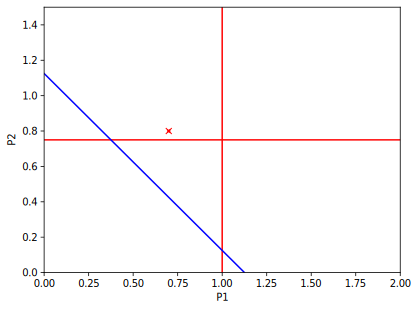

In [75]:
P01M, P02M = 1, .75
b01, b02 = 1, 2
P1, P2 = .7, .8
single_result(build_model_nb_abstract, P01M, P02M, b01, b02, P1, P2)

### result grid

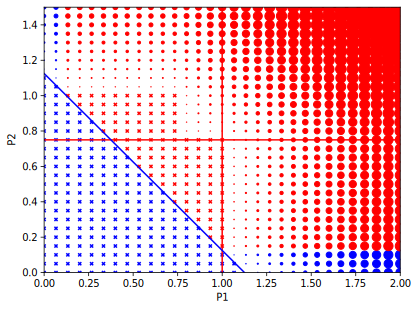

In [76]:
P01M, P02M = 1, .75
b01, b02 = 1, 2
nb, coef = 30, 2
grid_results(build_model_nb_abstract, solver, P01M, P02M, b01, b02, nb, coef)

# Branch switching only - general case

## DC power flow

The idea is just to see how to solve a DC-PF with an optimizer. There is nothing to minimize in particular, so let's minimize $\sum{\theta_i}$ with $\theta_i \ge 0$. Actually, removing the objective function works as well!!

In [2]:
@dataclass(frozen = True)
class Branch:
    b: float
    p_max: float

@dataclass(frozen = True)
class BranchId:
    bus1: str
    bus2: str
    
    def to_tuple(self):
        return self.bus1, self.bus2

def init_DC_model(p_buses: dict[str, float], branches: dict[BranchId, Branch], slack_id: str) -> pyo.AbstractModel:
    model = pyo.AbstractModel()
    model.big_M = pyo.Param(initialize = 1e3)
    model.bus_set = pyo.Set(initialize = p_buses.keys())
    model.bus_set_wo_slack = model.bus_set - {slack_id}
    model.branch_set = pyo.Set(dimen = 2, initialize = [br_id.to_tuple() for br_id in branches])

    model.p = pyo.Param(model.bus_set, initialize = p_buses)
    model.b = pyo.Param(model.branch_set, initialize = {b.to_tuple(): branches[b].b for b in branches})
    model.p_max = pyo.Param(model.branch_set, initialize = {b.to_tuple(): branches[b].p_max for b in branches})
    
    model.theta = pyo.Var(model.bus_set)
    
    model.slack = pyo.Constraint(rule = lambda m: m.theta[slack_id] == 0)
    
    return model

def bus_balance_constraint(model: pyo.AbstractModel, bus_p: dict[str, float]) -> None:
    def bus_constraint(model: pyo.AbstractModel, bus:str, bus_p:float) -> pyo.expr:
        return bus_p(model, bus) + sum(model.flows[b] for b in model.branch_set if b[0] == bus) - sum(model.flows[b] for b in model.branch_set if b[1] == bus) == 0
    model.bus_constraint = pyo.Constraint(model.bus_set_wo_slack, rule = lambda m,i : bus_constraint(m, i, bus_p))


def dc_pf(p_buses: dict[str, float], branches: dict[BranchId, Branch], slack_id: str) -> pyo.AbstractModel:
    model = init_DC_model(p_buses, branches, slack_id)
    model.flows = pyo.Var(model.branch_set, domain = pyo.Reals)
    
    bus_balance_constraint(model, lambda m, bus : m.p[bus])
    
    model.flow_constraint = pyo.Constraint(model.branch_set, rule = lambda m, b0, b1 : m.b[(b0,b1)] * (m.theta[b1] - m.theta[b0]) == m.flows[(b0,b1)])

    model.construct()
    return model

In [3]:
p_bus = {'0': 0, '1' : -2, '2': -1}
branches = {BranchId('0', '1') : Branch(1, 1), BranchId('1', '2') : Branch(1, 1), BranchId('0', '2') : Branch(1, 1)}

model = dc_pf(p_bus, branches, '0')
print(solver.solve(model))
model.pprint()


Problem: 
- Name: x1
  Lower bound: 1.0
  Upper bound: 1.0
  Number of objectives: 1
  Number of constraints: 6
  Number of variables: 7
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 7
  Number of nonzeros: 14
  Sense: minimize
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Wall time: 0.008061885833740234
  Error rc: 0
  Time: 0.1406259536743164
Solution: 
- number of solutions: 0
  number of solutions displayed: 0

4 Set Declarations
    branch_set : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     2 :    Any :    3 : {('0', '1'), ('1', '2'), ('0', '2')}
    bus_set : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domai

## DC OTS

### Flows

$|P_{ij}| \le \overline{P_{ij}} \implies P_{ij} \le \overline{P_{ij}}\ and\ -P_{ij} \le \overline{P_{ij}}$

$P_{ij} = b_{ij} (\theta_{i} - \theta_{j})$ if $i$ and $j$ connected.

Therefore, if $s_{ij} = 1$, $P_{ij} - b_{ij} (\theta_{i} - \theta_{j}) = 0$ and thus 
$\\ P_{ij} - b_{ij} (\theta_{i} - \theta_{j}) - ( 1 - s_{ij})M \le 0$
$\\ P_{ij} - b_{ij} (\theta_{i} - \theta_{j}) + (1 - s_{ij})M \ge 0$

if $s_{ij} = 0$ then $P_{ij} = 0$ and thus,
$\\ P_{ij} - s_{ij}M \le 0$
$\\ P_{ij} + s_{ij}M \ge 0$

at node $i$, $\underset{j \neq i}{\sum}{P_{ij}} + \sum{P_{i}^{+d,-g}} = 0$ and at least one sw is closed: $\sum{sw_{i,j}} \ge1$.


In [4]:
def dc_ots(p_buses:dict[str, float], branches:dict[BranchId, Branch], slack_id:str) -> pyo.AbstractModel:
    model = init_DC_model(p_buses, branches, slack_id)
    

    model.flows = pyo.Var(model.branch_set, bounds = lambda _, b0, b1: (-model.p_max[(b0, b1)], model.p_max[(b0, b1)]))
    model.ls = pyo.Var(model.bus_set_wo_slack, domain = pyo.NonNegativeReals, bounds = lambda model, b: (0, max(0, - model.p[b]))) # if p<0 => generator => no load shedding
    model.sw = pyo.Var(model.branch_set, domain = pyo.Binary)
    
    # model.connectivity = pyo.Constraint(model.bus_set, rule = lambda m, bus: sum(m.sw[(b[0], b[1])] for b in m.branch_set if b[0] == bus or b[1] == bus) >= 1)
    
    model.flow_close_le = pyo.Constraint(model.branch_set, rule = lambda m, b0, b1 : 
        m.flows[(b0,b1)] - m.b[(b0,b1)] * (m.theta[b0] - m.theta[b1]) - (1 - model.sw[(b0,b1)]) * model.big_M <= 0)
    model.flow_close_ge = pyo.Constraint(model.branch_set, rule = lambda m, b0, b1 : 
        m.flows[(b0,b1)] - m.b[(b0,b1)] * (m.theta[b0] - m.theta[b1]) + (1 - model.sw[(b0,b1)]) * model.big_M >= 0 )

    model.flow_open_le = pyo.Constraint(model.branch_set, rule = lambda m, b01, b02: m.flows[(b01,b02)] - m.sw[(b01,b02)] * model.big_M <=0)
    model.flow_open_ge = pyo.Constraint(model.branch_set, rule = lambda m, b01, b02: m.flows[(b01,b02)] + m.sw[(b01,b02)] * model.big_M >=0)
    
    def bus_p(model, bus):
        return model.p[bus] + model.ls[bus]
    
    bus_balance_constraint(model, bus_p)
    
    model.obj = pyo.Objective(rule = lambda m,i: pyo.summation(m.ls) - pyo.summation(m.sw) / 100,
                              sense = pyo.minimize)
    
    model.construct()
    return model

In [5]:
p_bus = {'0':0, '1':-1, '2':-2}
branches = {BranchId('0', '1') : Branch(1,3),
            BranchId('1', '2') : Branch(1,3),
            BranchId('0', '2') : Branch(1,3)}

model = dc_ots(p_bus, branches, '0')
print(solver.solve(model))
model.pprint()


Problem: 
- Name: x1
  Lower bound: -0.03
  Upper bound: -0.03
  Number of objectives: 1
  Number of constraints: 15
  Number of variables: 11
  Number of binary variables: 3
  Number of integer variables: 3
  Number of continuous variables: 8
  Number of nonzeros: 43
  Sense: minimize
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Wall time: 0.008476972579956055
  Error rc: 0
  Time: 0.08606386184692383
Solution: 
- number of solutions: 0
  number of solutions displayed: 0

4 Set Declarations
    branch_set : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     2 :    Any :    3 : {('0', '1'), ('1', '2'), ('0', '2')}
    bus_set : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen 

In [6]:
@dataclass(frozen=True)
class DetailedBranch:
    id: str
    bus1_id: str
    bus2_id: str
    v_nom1: float
    v_nom2: float
    b: float
    p: float
    
    def to_BranchId(self):
        return BranchId(self.bus1_id, self.bus2_id)


def convert_network(net:pp.network) -> tuple[dict[str, float], dict[BranchId, Branch], str, dict[BranchId, dict[str, str]]]:
    n_pu = pp.per_unit_view(net)
    
    def init_gen_load(p_bus:dict[str, float], df, label:str, sign: int) -> None:
        for d in df.index:
            p_bus[df.loc[d, 'bus_id']] += sign * df.loc[d, label]

    p_bus = {bus_id:0 for bus_id in n_pu.get_buses().index}
    init_gen_load(p_bus, n_pu.get_generators(), 'target_p', 1)
    init_gen_load(p_bus, n_pu.get_loads(), 'p0', -1)

    def init_branches(branches: dict[BranchId, Branch],
                      df,
                      index_branches: dict[BranchId, dict[str, str]],
                      br_type: str) -> None:
        for d in df.index:
            branches[BranchId(df.loc[d, 'bus1_id'], df.loc[d, 'bus2_id'])] = Branch(1/df.loc[d, 'x'], 10)
            index_branches[BranchId(df.loc[d, 'bus1_id'], df.loc[d, 'bus2_id'])] = {'id':d, 'br_type': br_type}

    branches: dict[BranchId, Branch] = {}
    index_branches: dict[BranchId, dict[str, str]] = {}
    init_branches(branches, n_pu.get_lines(), index_branches, 'line')
    init_branches(branches, n_pu.get_2_windings_transformers(),  index_branches, '2wd_tr')
    
    slack = max(p_bus, key = lambda bus: p_bus[bus])
    
    return p_bus, branches, slack, index_branches


def apply_results(network: pp.network, model: pyo.AbstractModel, index_branches: dict[BranchId, dict[str, str]]):
    n_pu = pp.per_unit_view(network)
    lines_id, lines_p, tr_id, tr_p = [], [], [], []
    for branch in model.branch_set:
        br = index_branches[BranchId(*branch)]
        if br['br_type'] == 'line' :
            lines_id.append(br['id'])
            lines_p.append(model.flows[branch].value)
        elif br['br_type'] == '2wd_tr':
            tr_id.append(br['id'])
            tr_p.append(model.flows[branch].value)
    n_pu.update_lines(id = lines_id, p2 = lines_p, p1 = [- p for p in lines_p])
    n_pu.update_2_windings_transformers(id=tr_id, p2 = tr_p, p1 = [-p for p in tr_p])
    n_pu.update_buses(id = model.bus_set, v_angle = [model.theta[bus].value for bus in model.bus_set], v_mag = [1 for _ in model.bus_set])

def retrieve_detailed_branches(net: pp.network)->dict[str, DetailedBranch]:
    n_pu = pp.per_unit_view(net)
    branches = {}
    vls = net.get_voltage_levels()
    
    def retrieve_from_df(df, d_branches:dict[str, DetailedBranch])-> None:
        for d in df.index:
            d_branches[d] = DetailedBranch(d,
                df.loc[d,'bus1_id'],
                df.loc[d,'bus2_id'],
                vls.loc[df.loc[d,'voltage_level1_id'], 'nominal_v'],
                vls.loc[df.loc[d,'voltage_level2_id'], 'nominal_v'],
                1 / df.loc[d, 'x'],
                df.loc[d, 'p1'])

    retrieve_from_df(n_pu.get_lines(), branches)
    retrieve_from_df(n_pu.get_2_windings_transformers(), branches)
    return branches

def init_branches_pmax(detailed_branches: dict[str, DetailedBranch],
                       pmax_fun: Callable[[DetailedBranch], float]) -> dict[BranchId, Branch]:
    branches_with_p_max: dict[BranchId, Branch] = {}
    for db_id in detailed_branches:
        db = detailed_branches[db_id]
        branches_with_p_max[db.to_BranchId()] = Branch(db.b, pmax_fun(db))
    return branches_with_p_max

def lim_ots_test(lim: float,
                 p_bus: dict[str, float],
                 d_branches:dict[str, DetailedBranch],
                 slack:str) -> tuple([pyo.AbstractModel, time, dict[BranchId, Branch]]):
    limited_branches = init_branches_pmax(d_branches, lambda d_br : lim if d_br.v_nom1 == 138.0 else 10)
    model_ots = dc_ots(p_bus, limited_branches, slack)
    start_time = time.time()
    solver.solve(model_ots)
    stop_time = time.time()
    return model_ots, stop_time - start_time, limited_branches

def indicators(model_res: pyo.AbstractModel) -> str:
    sw = [br for br in model_res.branch_set if model_res.sw[br].value == 0]
    ls = {br: model_res.ls[br].value for br in model_res.bus_set_wo_slack if abs(model_res.ls[br].value)>1e-5}
    return f"Open sw: {len(sw)} / {len(model_res.branch_set)}, sum(ls): {sum(ls.values()):.2f},\nsw: {sw},\nls: {ls}"

## Sample

In [8]:
create = pp.network.create_ieee118
net = create()
d_branches = retrieve_detailed_branches(net)
p_bus, branches, slack, index_branches = convert_network(net)       #TODO: type index_branches
model_dcpf = dc_pf(p_bus, branches, slack)
solver.solve(model_dcpf)
apply_results(net, model_dcpf, index_branches)

def retrieve_limited_branches(model: pyo.AbstractModel, limited_branches:dict[BranchId, Branch]) -> dict[BranchId, float]:
    return {br: abs(model.flows[br.to_tuple()].value/limited_branches[br].p_max) for br in limited_branches if model.flows[br.to_tuple()].value > limited_branches[br].p_max}

for lim in [1.7]:
    print(lim)
    model_ots, duration, limited_branches = lim_ots_test(lim, p_bus, d_branches, slack)
    prettyfy(retrieve_limited_branches(model_dcpf, limited_branches))
    print(f"duration: {duration:.1f} sec", indicators(model_ots))



1.7
{BranchId(bus1='VL49_0', bus2='VL66_0'): 1.0489360142402149}
duration: 0.3 sec Open sw: 2 / 179, sum(ls): 0.00,
sw: [('VL49_0', 'VL66_0'), ('VL90_0', 'VL91_0')],
ls: {}


| Line Limit | Duration (min:sec) | Open Sw (count / total) | Sum(ls) | Switches (sw)                                      | Line Status (ls)                              |
|------------|--------------------|--------------------------|---------|-----------------------------------------------------|-----------------------------------------------|
| 1.8        | 0:00               | 0 / 179                  | 0.00    | []                                                  | {}                                            |
| 1.7        | 0:00               | 2 / 179                  | 0.00    | [('VL49_0', 'VL66_0'), ('VL90_0', 'VL91_0')]       | {}                                            |
| 1.6        | 0:11               | 6 / 179                  | 0.00    | [('VL20_0', 'VL21_0'), ('VL42_0', 'VL49_0'), ('VL92_0', 'VL93_0'), ('VL92_0', 'VL94_0'), ('VL92_0', 'VL100_0'), ('VL92_0', 'VL102_0')] | {}                                            |
| 1.5        | 0:09               | 6 / 179                  | 0.01    | [('VL38_0', 'VL65_0'), ('VL49_0', 'VL66_0'), ('VL77_0', 'VL78_0'), ('VL77_0', 'VL80_0'), ('VL82_0', 'VL96_0'), ('VL68_0', 'VL69_0')] | {'VL90_0': 0.0063}                           |
| 1.4        | 0:28               | 7 / 179                  | 0.13    | [('VL49_0', 'VL66_0'), ('VL77_0', 'VL82_0'), ('VL94_0', 'VL95_0'), ('VL80_0', 'VL96_0'), ('VL94_0', 'VL96_0'), ('VL96_0', 'VL97_0'), ('VL26_0', 'VL25_0')] | {'VL88_0': 0.0135, 'VL90_0': 0.1201}         |
| 1.3        | 0:13               | 4 / 179                  | 0.33    | [('VL49_0', 'VL66_0'), ('VL90_0', 'VL91_0'), ('VL92_0', 'VL93_0'), ('VL26_0', 'VL25_0')] | {'VL90_0': 0.33}                             |
| 1.2        | 1:26               | 6 / 179                  | 0.43    | [('VL49_0', 'VL66_0'), ('VL90_0', 'VL91_0'), ('VL92_0', 'VL93_0'), ('VL92_0', 'VL94_0'), ('VL92_0', 'VL102_0'), ('VL26_0', 'VL25_0')] | {'VL90_0': 0.43}                             |
| 1.1        | 31:45              | 10 / 179                 | 0.58    | [('VL15_0', 'VL19_0'), ('VL29_0', 'VL31_0'), ('VL49_0', 'VL66_0'), ('VL90_0', 'VL91_0'), ('VL92_0', 'VL93_0'), ('VL92_0', 'VL94_0'), ('VL92_0', 'VL102_0'), ('VL103_0', 'VL104_0'), ('VL75_0', 'VL118_0'), ('VL26_0', 'VL25_0')] | {'VL60_0': 0.0212, 'VL88_0': 0.0306, 'VL90_0': 0.53} |


{BranchId(bus1='VL49_0', bus2='VL66_0'): 1.0489360142402149}
Open sw: 2 / 179, sum(ls): 0.00,
sw: [('VL49_0', 'VL66_0'), ('VL90_0', 'VL91_0')],
ls: {}


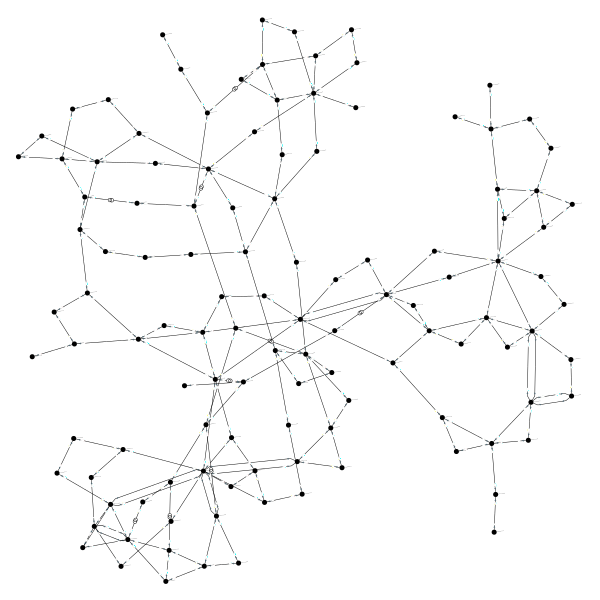

In [52]:
# model_ots, duration, limited_branches = lim_ots_test(1.5, p_bus, d_branches, slack)
prettyfy(retrieve_limited_branches(model_dcpf, limited_branches))

apply_results(net, model_ots, index_branches)
print(indicators(model_ots))
net.get_network_area_diagram()


In [54]:
net = create()
p_bus, branches, slack, index_branches = convert_network(net)
model = dc_pf(p_bus, branches, slack)
print(solver.solve(model))


Problem: 
- Name: x1
  Lower bound: 1.0
  Upper bound: 1.0
  Number of objectives: 1
  Number of constraints: 297
  Number of variables: 298
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 298
  Number of nonzeros: 892
  Sense: minimize
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Wall time: 0.0006570816040039062
  Error rc: 0
  Time: 0.0492711067199707
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



In [55]:
net = create()
p_bus, branches, slack, index_branches = convert_network(net)
model = dc_pf(p_bus, branches, slack)
print(solver.solve(model))


Problem: 
- Name: x1
  Lower bound: 1.0
  Upper bound: 1.0
  Number of objectives: 1
  Number of constraints: 297
  Number of variables: 298
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 298
  Number of nonzeros: 892
  Sense: minimize
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Wall time: 0.0005869865417480469
  Error rc: 0
  Time: 0.0394291877746582
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



# grid2op

In [20]:
import grid2op
from tqdm.notebook import tqdm  # for easy progress bar
display_tqdm = False  # this is set to False for ease with the unitt test, feel free to set it to True
from grid2op.PlotGrid import PlotMatplot
env = grid2op.make("l2rpn_case14_sandbox", test=True)

/Users/benoitjeanson/vsCode/TUD/topo_sandbox/.venv/lib/python3.11/site-packages/grid2op/MakeEnv/Make.py:420: UserWarning: You are using a development environment. This environment is not intended for training agents. It might not be up to date and its primary use if for tests (hence the "test=True" you passed as argument). Use at your own risk.
  warnings.warn(_MAKE_DEV_ENV_WARN)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution

In [21]:
obs = env.reset()

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



In [22]:
obs.name_line

array(['0_1_0', '0_4_1', '1_2_2', '1_3_3', '1_4_4', '2_3_5', '3_4_6',
       '5_10_7', '5_11_8', '5_12_9', '8_9_10', '8_13_11', '9_10_12',
       '11_12_13', '12_13_14', '3_6_15', '3_8_16', '4_5_17', '6_7_18',
       '6_8_19'], dtype='<U8')

In [4]:
import grid2op
# create an environment
env_name = "l2rpn_case14_sandbox"  # for example, other environments might be usable
env = grid2op.make(env_name)

# create an agent
from grid2op.Agent import RandomAgent
my_agent = RandomAgent(env.action_space)

# proceed as you would any open ai gym loop
nb_episode = 10
for _ in range(nb_episode):
    # you perform in this case 10 different episodes
    obs = env.reset()
    reward = env.reward_range[0]
    done = False
    while not done:
        # here you loop on the time steps: at each step your agent receive an observation
        # takes an action
        # and the environment computes the next observation that will be used at the next step.
        act = my_agent.act(obs, reward, done)
        obs, reward, done, info = env.step(act)

downloading the training data, this may take a while.


l2rpn_case14_sandbox.tar.bz2: 294MB [00:27, 10.8MB/s]                              


Extract the tar archive in "/Users/benoitjeanson/data_grid2op"
	 Successfully updated file "config.py" for environment "l2rpn_case14_sandbox"


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



	 Successfully updated file "grid.json" for environment "l2rpn_case14_sandbox"
You may now use the environment "l2rpn_case14_sandbox" with the available data by invoking:
	env = grid2op.make("l2rpn_case14_sandbox")


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install nu